In [1]:
import torchxrayvision as xrv

C:\Users\Hoo Kai Sng\OneDrive - National University of Singapore\Documents\NUS\CS3244\Project\xrayenv\Lib\site-packages\torchxrayvision\utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
d = xrv.datasets.COVID19_Dataset(imgpath="data/images/", csvpath="data/csv/metadata.csv")

In [3]:
img = d[0]['img'][0]
print(f"sample image of shape {img.shape}")
print(f"dataset of length {len(d)}")
print(img)

sample image of shape (888, 882)
dataset of length 535
[[1024.      1015.9686  1007.93726 ... -469.83527 -477.86664 -477.86664]
 [1024.      1024.      1015.9686  ... -493.92938 -493.92938 -493.92938]
 [1024.      1024.      1015.9686  ... -501.96075 -509.99213 -509.99213]
 ...
 [1024.      1024.       983.84314 ... -172.6745  -156.61176 -148.58038]
 [1024.      1024.       983.84314 ... -252.98822 -244.95685 -244.95685]
 [1024.      1024.       983.84314 ... -437.70978 -429.6784  -421.64703]]


In [4]:
import torchxrayvision as xrv
from preprocess import *
from dataset import *
from models import *
from evaluation import *
from explain import *

#### Global Variables

In [5]:
d = xrv.datasets.COVID19_Dataset(imgpath = "data/images/", csvpath = "data/csv/metadata.csv")
BATCH_SIZE = 16
pos_idx, neg_idx = find_positive(d), find_negative(d)
sample_img_pos, sample_img_neg = d[pos_idx]['img'][0], d[neg_idx]['img'][0]
sample_input_pos, sample_input_neg = tensorize_image(sample_img_pos).unsqueeze(0), tensorize_image(sample_img_neg).unsqueeze(0)

#### Unsampled Data

##### Data preparation

In [6]:
unsampled_d = preprocess(d, resample = False)
explore_data(unsampled_d, processed = True)

unsampled_train_dataset = Covid19DataSet('train', unsampled_d)
unsampled_validation_dataset = Covid19DataSet('val', unsampled_d)
unsampled_test_dataset = Covid19DataSet('test', unsampled_d)
unsampled_train_loader = DataLoader(dataset = unsampled_train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
unsampled_validation_loader = DataLoader(dataset = unsampled_validation_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
unsampled_test_loader = DataLoader(dataset = unsampled_test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

Data Size: 535 | Postives: 342 | Negatives: 193


##### Linear Net

Training model
Training completed in 7mins 26.55s
Best Loss: 0.0829 | Training F1: 0.7606
Precision: 0.6698 | Recall: 0.9861 | F1: 0.7978 | Predicted positives: 106 | Predicted negatives: 1 | Total: 107
Precision: 0.6137 | Recall: 1.0000 | F1: 0.7606 | Predicted positives: 321 | Predicted negatives: 0 | Total: 321


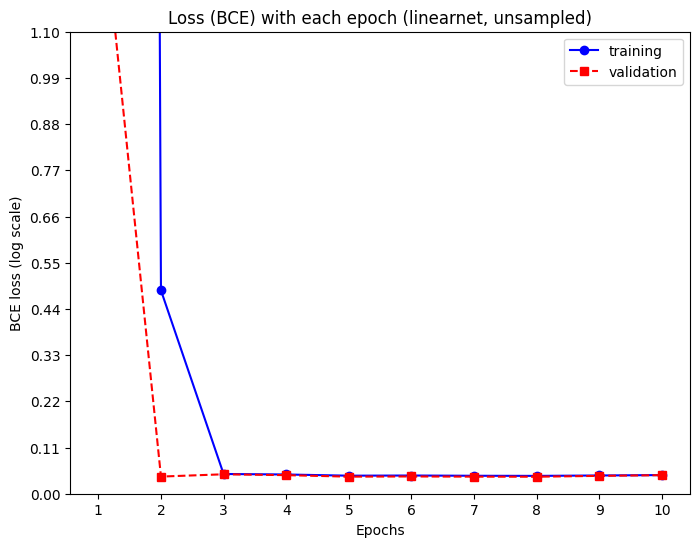

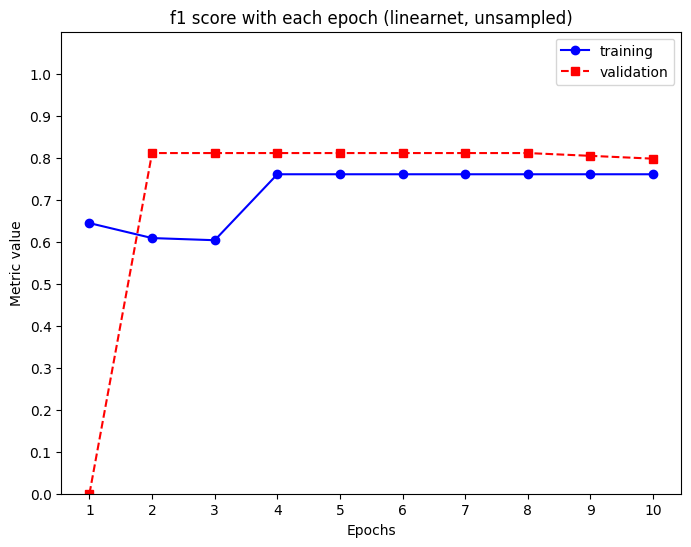

In [7]:
linearnet_v_us = LinearNet()
linearnet_us, linearnet_stats_us = train_model(linearnet_v_us, unsampled_train_loader, unsampled_validation_loader, epochs = 10)
ln_t_loss_us, ln_t_prec_us, ln_t_rec_us, ln_t_f1_us, ln_v_loss_us, ln_v_prec_us, ln_v_rec_us, ln_v_f1_us, ln_time_us = linearnet_stats_us
ln_test_prec_us, ln_test_rec_us, ln_test_f1_us, *ln_test_rest_us = get_metrics(linearnet_us, unsampled_test_loader)
ln_train_prec_us, ln_train_rec_us, ln_train_f1_us, *ln_train_rest_us = get_metrics(linearnet_us, unsampled_train_loader)
ln_us_pred_pos = 'positive' if (torch.sigmoid(linearnet_us(sample_input_pos)) >= 0.5).item() else 'negative'
ln_us_pred_neg = 'positive' if (torch.sigmoid(linearnet_us(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, ln_t_loss_us, ln_v_loss_us, 'linearnet, unsampled')
plot_metric(10, ln_t_f1_us, ln_v_f1_us, 'f1 score with each epoch (linearnet, unsampled)')

##### ConvNet

Training model
Training completed in 1mins 11.95s
Best Loss: 0.0846 | Training F1: 0.7606
Precision: 0.6729 | Recall: 1.0000 | F1: 0.8045 | Predicted positives: 107 | Predicted negatives: 0 | Total: 107
Precision: 0.6137 | Recall: 1.0000 | F1: 0.7606 | Predicted positives: 321 | Predicted negatives: 0 | Total: 321


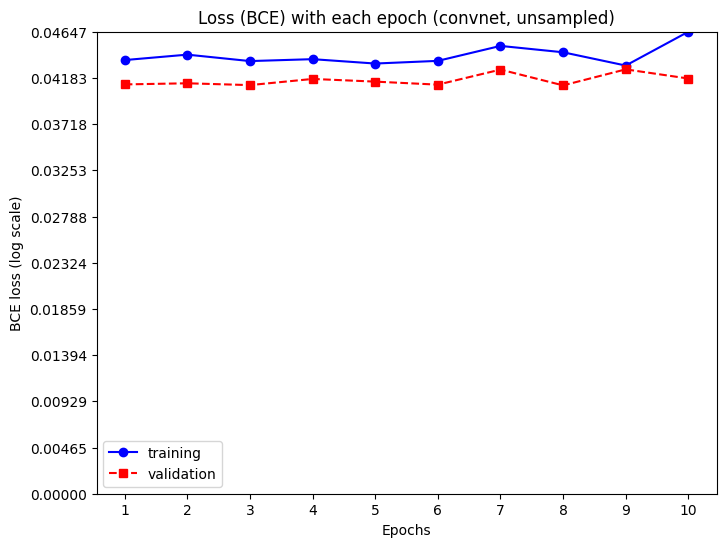

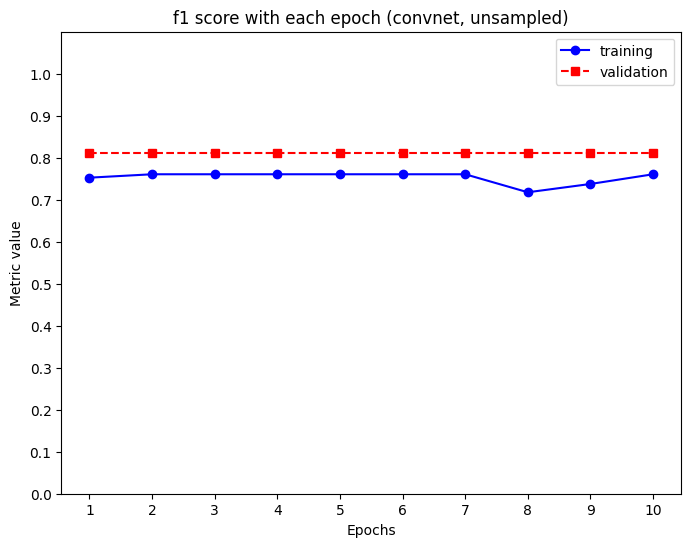

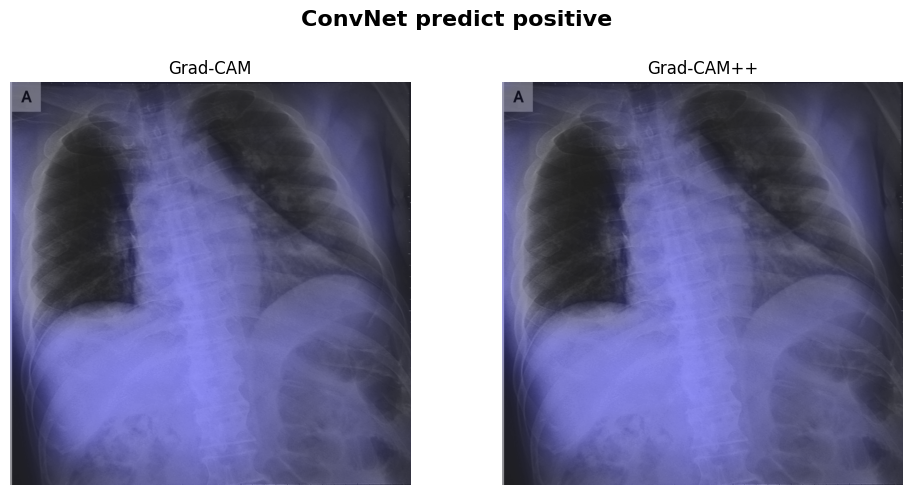

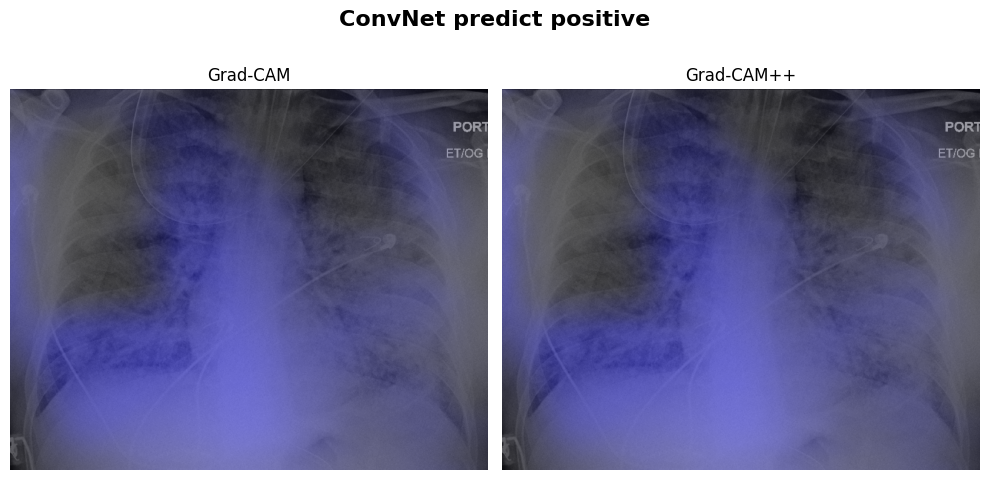

In [8]:
convnet_v_us = ConvNet()
convnet_us, convnet_stats_us = train_model(convnet_v_us, unsampled_train_loader, unsampled_validation_loader, epochs = 10)
cn_t_loss_us, cn_t_prec_us, cn_t_rec_us, cn_t_f1_us, cn_v_loss_us, cn_v_prec_us, cn_v_rec_us, cn_v_f1_us, cn_time_us = convnet_stats_us
cn_test_prec_us, cn_test_rec_us, cn_test_f1_us, *cn_test_rest_us = get_metrics(convnet_us, unsampled_test_loader)
cn_train_prec_us, cn_train_rec_us, cn_train_f1_us, *cn_train_rest_us = get_metrics(convnet_us, unsampled_train_loader)
cn_us_pred_pos = 'positive' if (torch.sigmoid(convnet_us(sample_input_pos)) >= 0.5).item() else 'negative'
cn_us_pred_neg = 'positive' if (torch.sigmoid(convnet_us(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, cn_t_loss_us, cn_v_loss_us, 'convnet, unsampled')
plot_metric(10, cn_t_f1_us, cn_v_f1_us, 'f1 score with each epoch (convnet, unsampled)')

for param in convnet_us.parameters():
    param.requires_grad = True
vis_comparison(convnet_us, sample_img_pos, sample_input_pos, f'ConvNet predict {cn_us_pred_pos}')
vis_comparison(convnet_us, sample_img_neg, sample_input_pos, f'ConvNet predict {cn_us_pred_neg}')

##### ResNet

Training model
Training completed in 3mins 10.54s
Best Loss: 0.0629 | Training F1: 0.8778
Precision: 0.8393 | Recall: 0.6528 | F1: 0.7344 | Predicted positives: 56 | Predicted negatives: 51 | Total: 107
Precision: 0.9435 | Recall: 0.8477 | F1: 0.8930 | Predicted positives: 177 | Predicted negatives: 144 | Total: 321


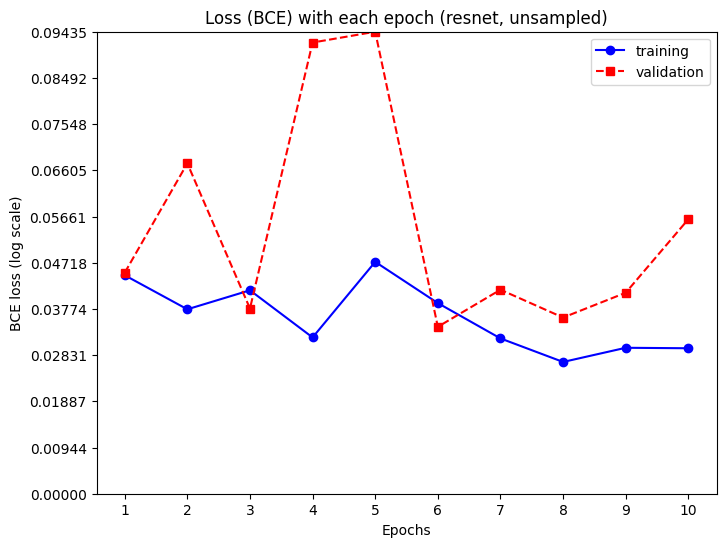

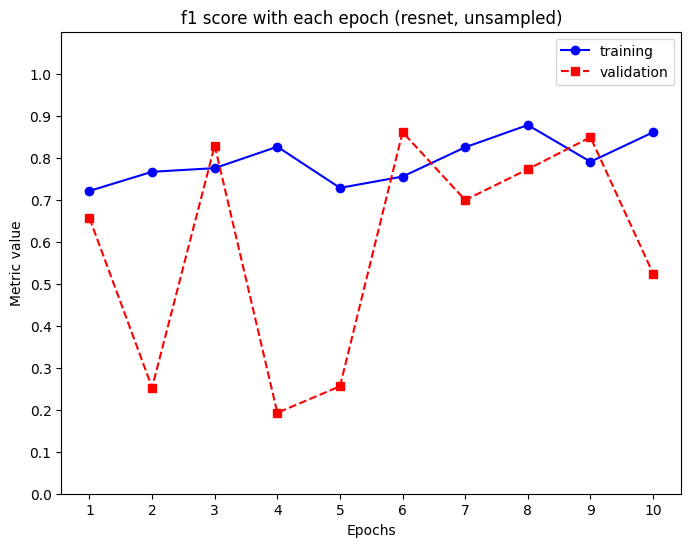

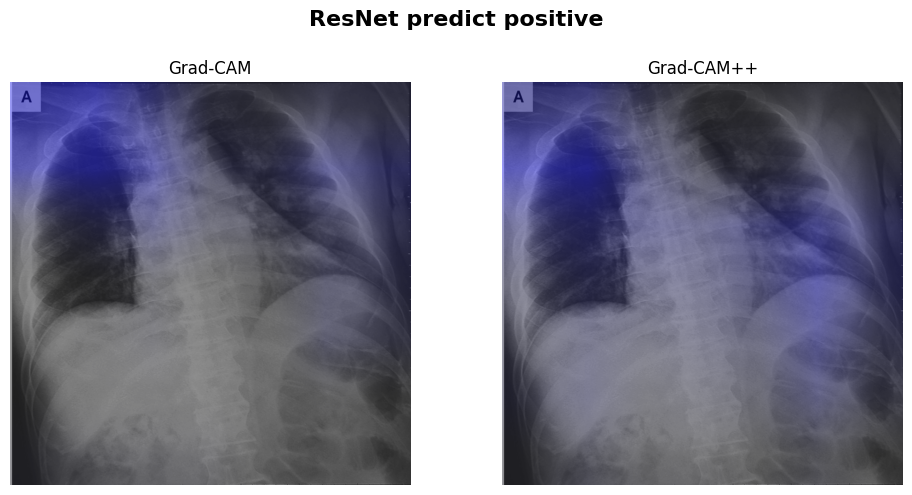

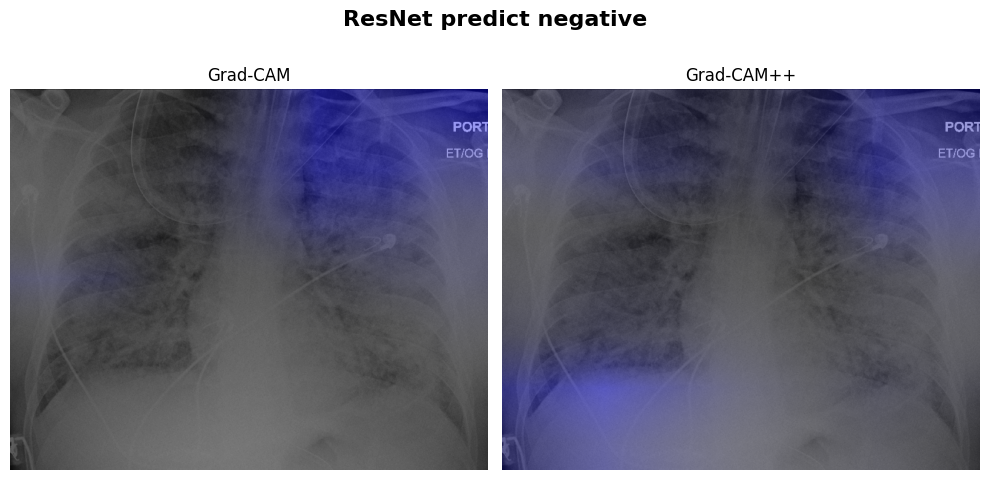

In [9]:
resnet_v_us = MyResNet18()
resnet_us, resnet_stats_us = train_model(resnet_v_us, unsampled_train_loader, unsampled_validation_loader, epochs = 10)
rn_t_loss_us, rn_t_prec_us, rn_t_rec_us, rn_t_f1_us, rn_v_loss_us, rn_v_prec_us, rn_v_rec_us, rn_v_f1_us, rn_time_us = resnet_stats_us
rn_test_prec_us, rn_test_rec_us, rn_test_f1_us, *rn_test_rest_us = get_metrics(resnet_us, unsampled_test_loader)
rn_train_prec_us, rn_train_rec_us, rn_train_f1_us, *rn_train_rest_us = get_metrics(resnet_us, unsampled_train_loader)
rn_us_pred_pos = 'positive' if (torch.sigmoid(resnet_us(sample_input_pos)) >= 0.5).item() else 'negative'
rn_us_pred_neg = 'positive' if (torch.sigmoid(resnet_us(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, rn_t_loss_us, rn_v_loss_us, 'resnet, unsampled')
plot_metric(10, rn_t_f1_us, rn_v_f1_us, 'f1 score with each epoch (resnet, unsampled)')

for param in resnet_us.parameters():
    param.requires_grad = True
vis_comparison(resnet_us, sample_img_pos, sample_input_pos, f'ResNet predict {rn_us_pred_pos}')
vis_comparison(resnet_us, sample_img_neg, sample_input_neg, f'ResNet predict {rn_us_pred_neg}')

##### Densenet

Training model
Training completed in 7mins 6.70s
Best Loss: 0.0519 | Training F1: 0.9262
Precision: 0.7568 | Recall: 0.7778 | F1: 0.7671 | Predicted positives: 74 | Predicted negatives: 33 | Total: 107
Precision: 0.9159 | Recall: 0.9949 | F1: 0.9538 | Predicted positives: 214 | Predicted negatives: 107 | Total: 321


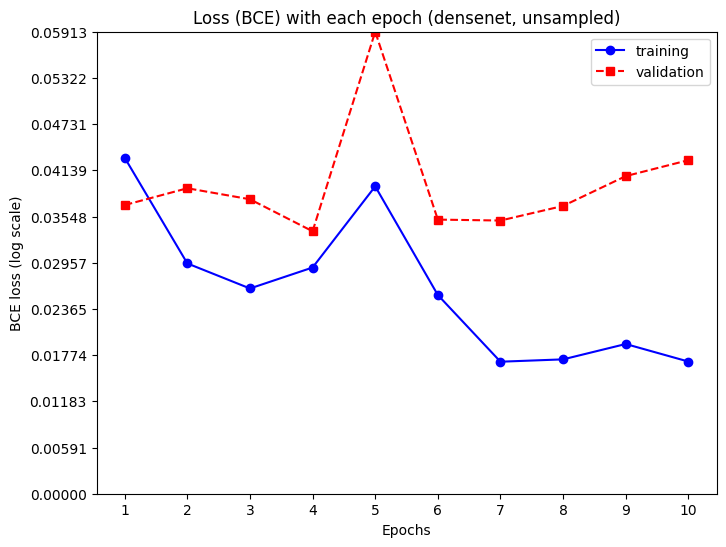

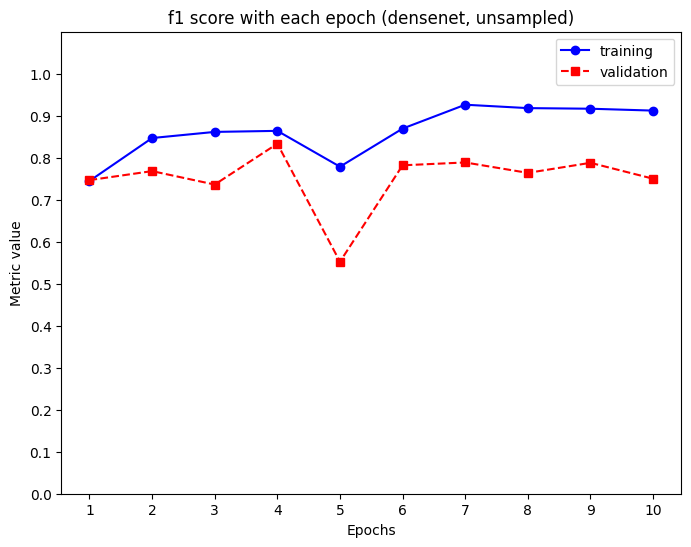

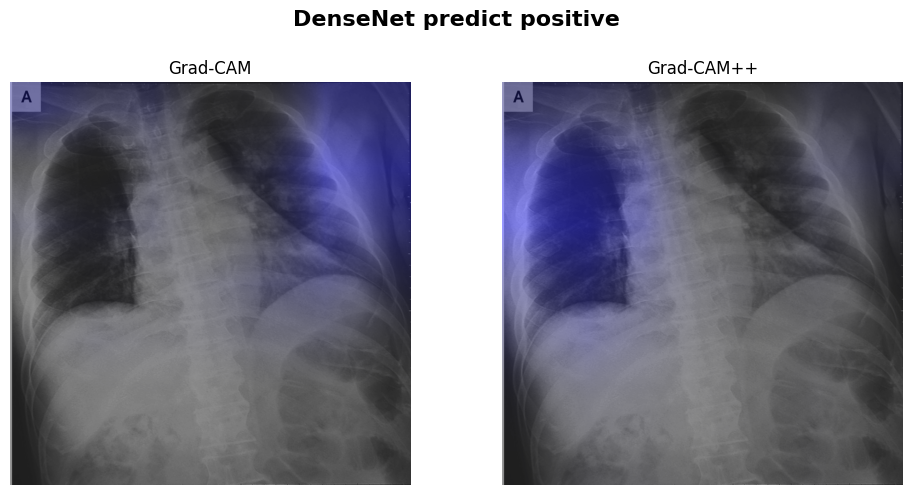

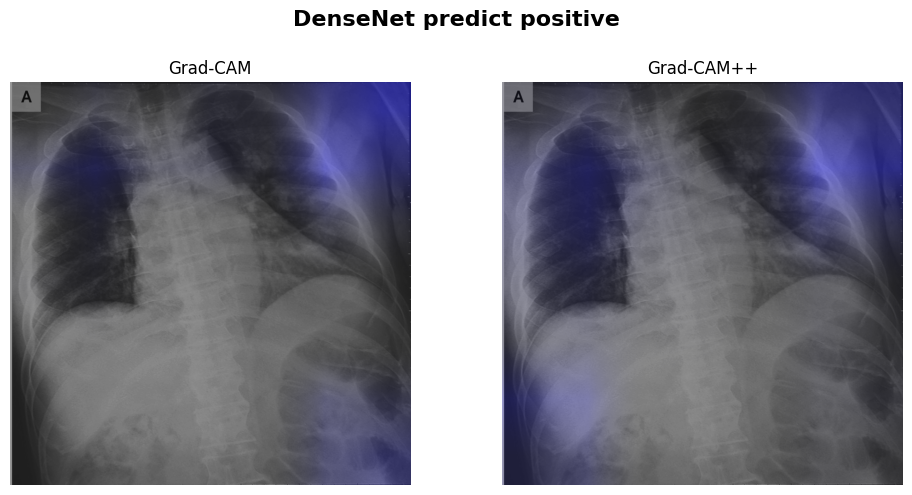

In [10]:
densenet_v_us = MyDenseNet()
densenet_us, densenet_stats_us = train_model(densenet_v_us, unsampled_train_loader, unsampled_validation_loader, epochs = 10)
dn_t_loss_us, dn_t_prec_us, dn_t_rec_us, dn_t_f1_us, dn_v_loss_us, dn_v_prec_us, dn_v_rec_us, dn_v_f1_us, dn_time_us = densenet_stats_us
dn_test_prec_us, dn_test_rec_us, dn_test_f1_us, *dn_test_rest_us = get_metrics(densenet_us, unsampled_test_loader)
dn_train_prec_us, dn_train_rec_us, dn_train_f1_us, *dn_train_rest_us = get_metrics(densenet_us, unsampled_train_loader)
dn_us_pred_pos = 'positive' if (torch.sigmoid(densenet_us(sample_input_pos)) >= 0.5).item() else 'negative'
dn_us_pred_neg = 'positive' if (torch.sigmoid(densenet_us(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, dn_t_loss_us, dn_v_loss_us, 'densenet, unsampled')
plot_metric(10, dn_t_f1_us, dn_v_f1_us, 'f1 score with each epoch (densenet, unsampled)')

for param in densenet_us.parameters():
    param.requires_grad = True
vis_comparison(densenet_us, sample_img_pos, sample_input_pos, f'DenseNet predict {dn_us_pred_pos}')
vis_comparison(densenet_us, sample_img_pos, sample_input_neg, f'DenseNet predict {dn_us_pred_neg}')

##### Models comparison

In [11]:
headers = ['Model', 'Precision', 'Recall', 'F1 Score']
unsampled_metrics = [
    ['linearnet (train)', ln_train_prec_us, ln_train_rec_us, ln_train_f1_us],
    ['linearnet (test)', ln_test_prec_us, ln_test_rec_us, ln_test_f1_us],
    ['convnet (train)', cn_train_prec_us, cn_train_rec_us, cn_train_f1_us],
    ['convnet (test)', cn_test_prec_us, cn_test_rec_us, cn_test_f1_us],
    ['resnet (train)', rn_train_prec_us, rn_train_rec_us, rn_train_f1_us],
    ['resnet (test)', rn_test_prec_us, rn_test_rec_us, rn_test_f1_us],
    ['densenet (train)', dn_train_prec_us, dn_train_rec_us, dn_train_f1_us],
    ['densenet (test)', dn_test_prec_us, dn_test_rec_us, dn_test_f1_us]
]
create_table(headers, unsampled_metrics)

| Model | Precision | Recall | F1 Score |
| :- | :- | :- | :- |
| linearnet (train) | 1.0 | 0.6137 | 0.7606 |
| linearnet (test) | 0.9861 | 0.6698 | 0.7978 |
| convnet (train) | 1.0 | 0.6137 | 0.7606 |
| convnet (test) | 1.0 | 0.6729 | 0.8045 |
| resnet (train) | 0.8477 | 0.9435 | 0.893 |
| resnet (test) | 0.6528 | 0.8393 | 0.7344 |
| densenet (train) | 0.9949 | 0.9159 | 0.9538 |
| densenet (test) | 0.7778 | 0.7568 | 0.7671 |



| Model | Precision | Recall | F1 Score |
| :- | :- | :- | :- |
| linearnet (train) | 1.0 | 0.6137 | 0.7606 |
| linearnet (test) | 0.9861 | 0.6698 | 0.7978 |
| convnet (train) | 1.0 | 0.6137 | 0.7606 |
| convnet (test) | 1.0 | 0.6729 | 0.8045 |
| resnet (train) | 0.8477 | 0.9435 | 0.893 |
| resnet (test) | 0.6528 | 0.8393 | 0.7344 |
| densenet (train) | 0.9949 | 0.9159 | 0.9538 |
| densenet (test) | 0.7778 | 0.7568 | 0.7671 |

#### Resampled Data

##### Data preparation

In [12]:
resampled_d = preprocess(d, resample = True)
explore_data(resampled_d, processed = True)

resampled_train_dataset = Covid19DataSet('train', resampled_d)
resampled_validation_dataset = Covid19DataSet('val', resampled_d)
resampled_test_dataset = Covid19DataSet('test', resampled_d)
resampled_train_loader = DataLoader(dataset = resampled_train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
resampled_validation_loader = DataLoader(dataset = resampled_validation_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
resampled_test_loader = DataLoader(dataset = resampled_test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

Data Size: 728 | Postives: 342 | Negatives: 386


In [22]:
t_pos, t_neg = 0, 0
for i, (image, label) in enumerate(resampled_train_dataset):
    t_pos += label.item()
    t_neg += (label.item() == 0)
print(t_pos, t_neg)

196.0 240


In [23]:
f_pos, f_neg = 0, 0
for i, (image, label) in enumerate(resampled_test_dataset):
    f_pos += label.item()
    f_neg += (label.item() == 0)
print(f_pos, f_neg)

77.0 69


##### LinearNet

Training model
Training completed in 10mins 20.66s
Best Loss: 0.0948 | Training F1: 0.2662
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Predicted positives: 0 | Predicted negatives: 146 | Total: 146
Precision: 1.0000 | Recall: 0.0051 | F1: 0.0102 | Predicted positives: 1 | Predicted negatives: 435 | Total: 436


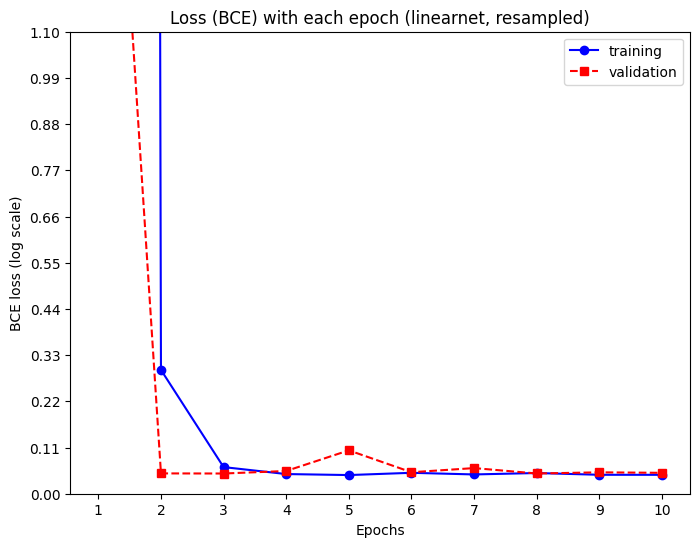

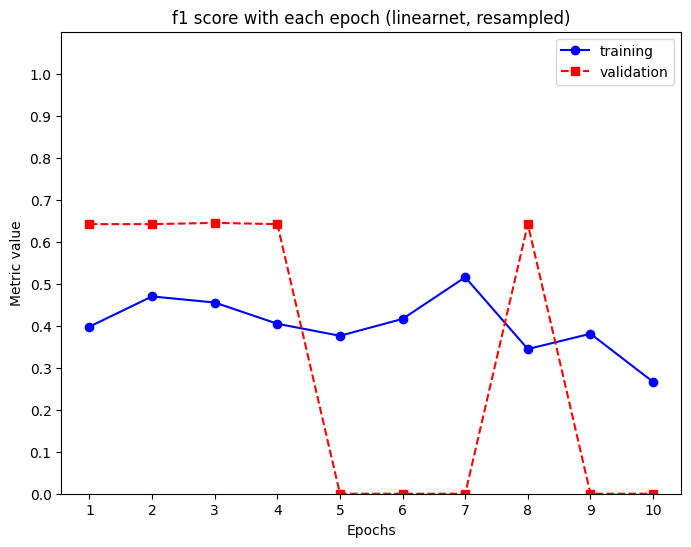

In [13]:
linearnet_v_rs = LinearNet()
linearnet_rs, linearnet_stats_rs = train_model(linearnet_v_rs, resampled_train_loader, resampled_validation_loader, epochs = 10)
ln_t_loss_rs, ln_t_prec_rs, ln_t_rec_rs, ln_t_f1_rs, ln_v_loss_rs, ln_v_prec_rs, ln_v_rec_rs, ln_v_f1_rs, ln_time_rs = linearnet_stats_rs
ln_test_prec_rs, ln_test_rec_rs, ln_test_f1_rs, *ln_test_rest_rs = get_metrics(linearnet_rs, resampled_test_loader)
ln_train_prec_rs, ln_train_rec_rs, ln_train_f1_rs, *ln_train_rest_rs = get_metrics(linearnet_rs, resampled_train_loader)
ln_rs_pred_pos = 'positive' if (torch.sigmoid(linearnet_rs(sample_input_pos)) >= 0.5).item() else 'negative'
ln_rs_pred_neg = 'positive' if (torch.sigmoid(linearnet_rs(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, ln_t_loss_rs, ln_v_loss_rs, 'linearnet, resampled')
plot_metric(10, ln_t_f1_rs, ln_v_f1_rs, 'f1 score with each epoch (linearnet, resampled)')

##### ConvNet

Training model
Training completed in 1mins 41.18s
Best Loss: 0.0920 | Training F1: 0.0811
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Predicted positives: 0 | Predicted negatives: 146 | Total: 146
Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Predicted positives: 0 | Predicted negatives: 436 | Total: 436


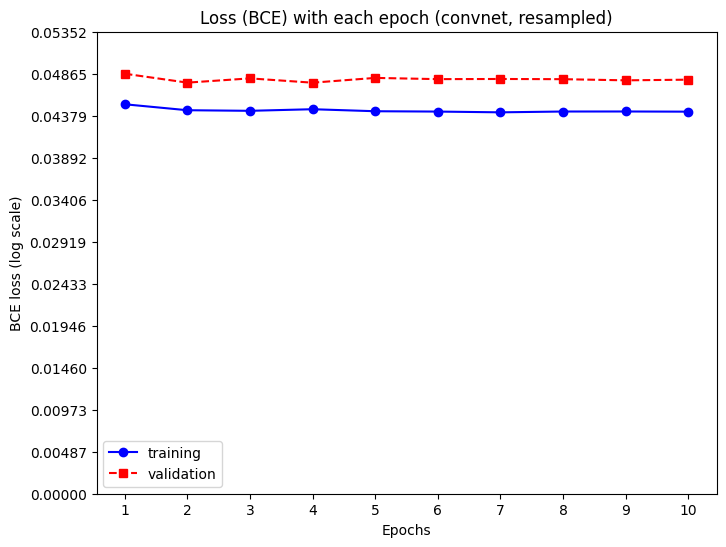

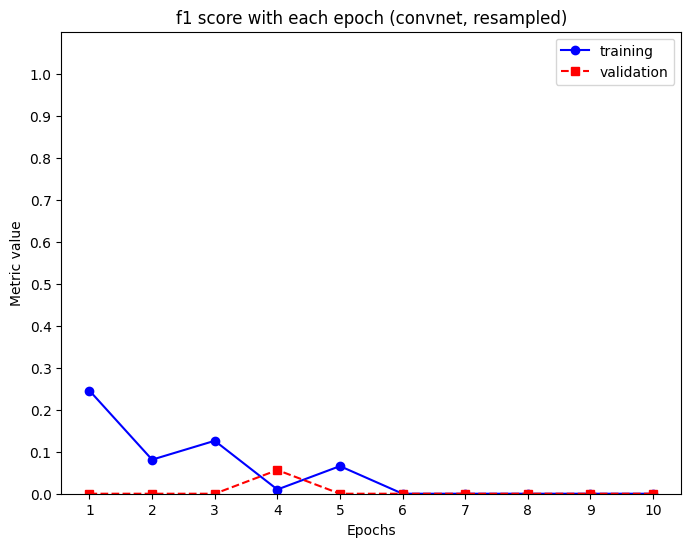

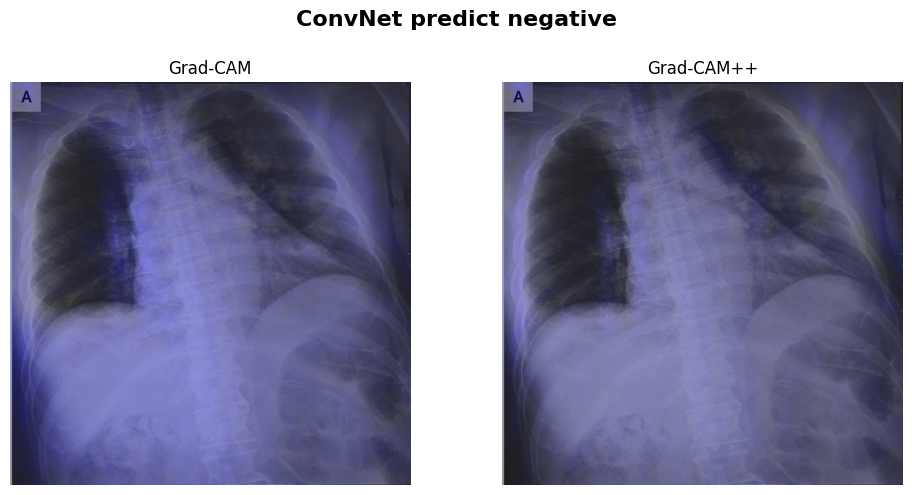

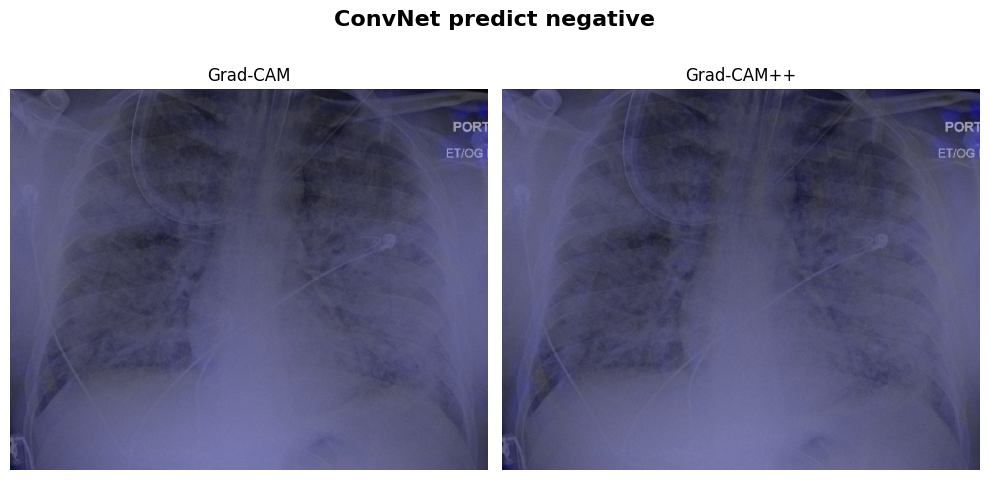

In [14]:
convnet_v_rs = ConvNet()
convnet_rs, convnet_stats_rs = train_model(convnet_v_rs, resampled_train_loader, resampled_validation_loader, epochs = 10)
cn_t_loss_rs, cn_t_prec_rs, cn_t_rec_rs, cn_t_f1_rs, cn_v_loss_rs, cn_v_prec_rs, cn_v_rec_rs, cn_v_f1_rs, cn_time_rs = convnet_stats_rs
cn_test_prec_rs, cn_test_rec_rs, cn_test_f1_rs, *cn_test_rest_rs = get_metrics(convnet_rs, resampled_test_loader)
cn_train_prec_rs, cn_train_rec_rs, cn_train_f1_rs, *cn_train_rest_rs = get_metrics(convnet_rs, resampled_train_loader)
cn_rs_pred_pos = 'positive' if (torch.sigmoid(convnet_rs(sample_input_pos)) >= 0.5).item() else 'negative'
cn_rs_pred_neg = 'positive' if (torch.sigmoid(convnet_rs(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, cn_t_loss_rs, cn_v_loss_rs, 'convnet, resampled')
plot_metric(10, cn_t_f1_rs, cn_v_f1_rs, 'f1 score with each epoch (convnet, resampled)')

for param in convnet_rs.parameters():
    param.requries_grad = True
vis_comparison(convnet_rs, sample_img_pos, sample_input_pos, f'ConvNet predict {cn_rs_pred_pos}')
vis_comparison(convnet_rs, sample_img_neg, sample_input_neg, f'ConvNet predict {cn_rs_pred_neg}')

##### ResNet

Training model
Training completed in 4mins 22.57s
Best Loss: 0.0587 | Training F1: 0.8389
Precision: 0.7021 | Recall: 0.8571 | F1: 0.7719 | Predicted positives: 94 | Predicted negatives: 52 | Total: 146
Precision: 0.7720 | Recall: 0.9847 | F1: 0.8655 | Predicted positives: 250 | Predicted negatives: 186 | Total: 436


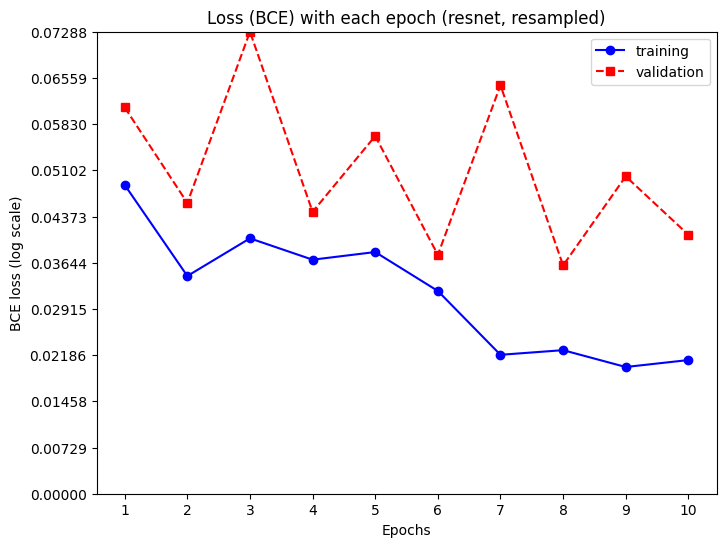

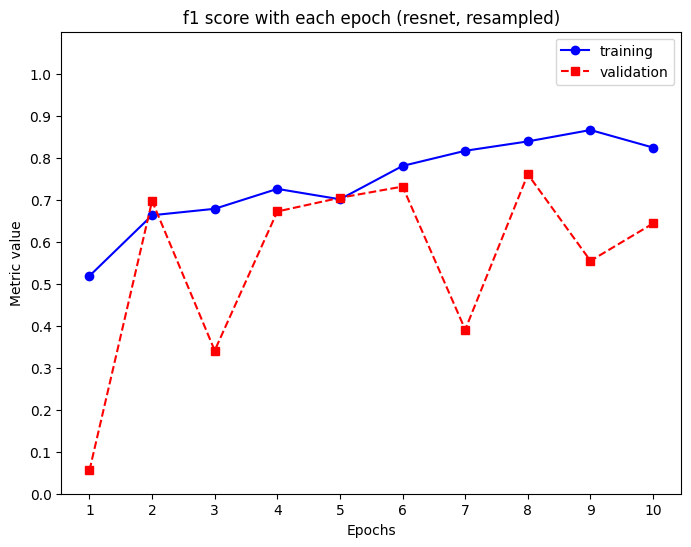

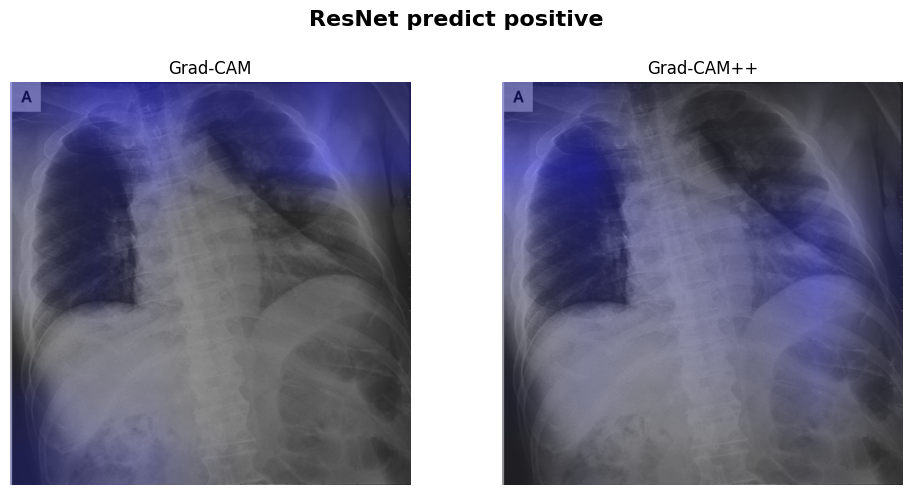

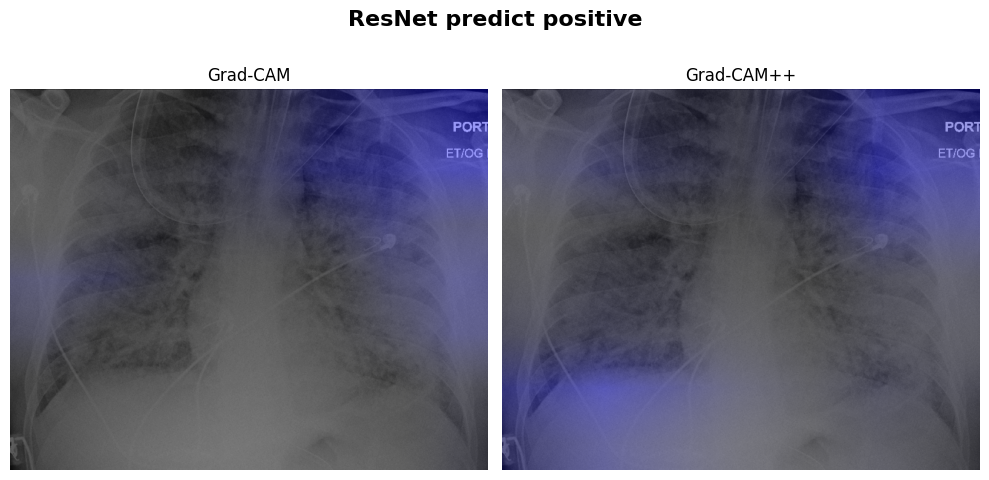

In [15]:
resnet_v_rs = MyResNet18()
resnet_rs, resnet_stats_rs = train_model(resnet_v_rs, resampled_train_loader, resampled_validation_loader, epochs = 10)
rn_t_loss_rs, rn_t_prec_rs, rn_t_rec_rs, rn_t_f1_rs, rn_v_loss_rs, rn_v_prec_rs, rn_v_rec_rs, rn_v_f1_rs, rn_time_rs = resnet_stats_rs
rn_test_prec_rs, rn_test_rec_rs, rn_test_f1_rs, *rn_test_rest_rs = get_metrics(resnet_rs, resampled_test_loader)
rn_train_prec_rs, rn_train_rec_rs, rn_train_f1_rs, *rn_train_rest_rs = get_metrics(resnet_rs, resampled_train_loader)
rn_rs_pred_pos = 'positive' if (torch.sigmoid(resnet_rs(sample_input_pos)) >= 0.5).item() else 'negative'
rn_rs_pred_neg = 'positive' if (torch.sigmoid(resnet_rs(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, rn_t_loss_rs, rn_v_loss_rs, 'resnet, resampled')
plot_metric(10, rn_t_f1_rs, rn_v_f1_rs, 'f1 score with each epoch (resnet, resampled)')

for param in resnet_rs.parameters():
    param.requires_grad = True
vis_comparison(resnet_rs, sample_img_pos, sample_input_pos, f'ResNet predict {rn_rs_pred_pos}')
vis_comparison(resnet_rs, sample_img_neg, sample_input_neg, f'ResNet predict {rn_rs_pred_neg}')

##### DenseNet

Training model
Training completed in 9mins 44.80s
Best Loss: 0.0684 | Training F1: 0.8380
Precision: 0.8592 | Recall: 0.7922 | F1: 0.8243 | Predicted positives: 71 | Predicted negatives: 75 | Total: 146
Precision: 0.8364 | Recall: 0.9133 | F1: 0.8732 | Predicted positives: 214 | Predicted negatives: 222 | Total: 436


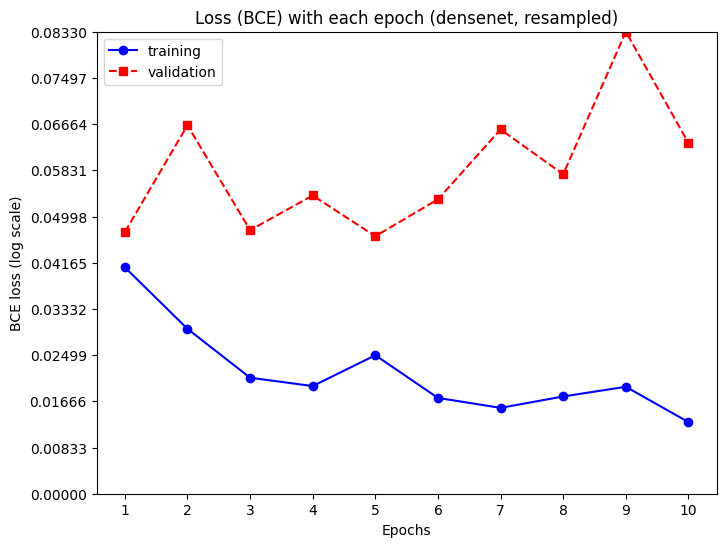

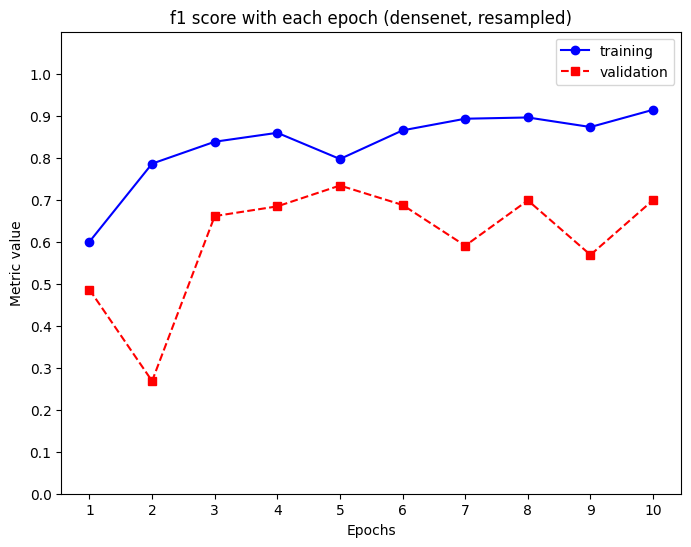

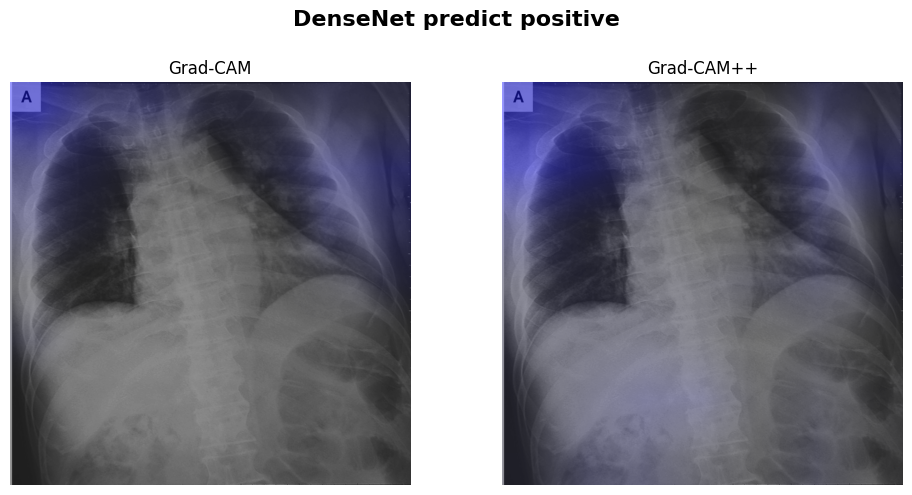

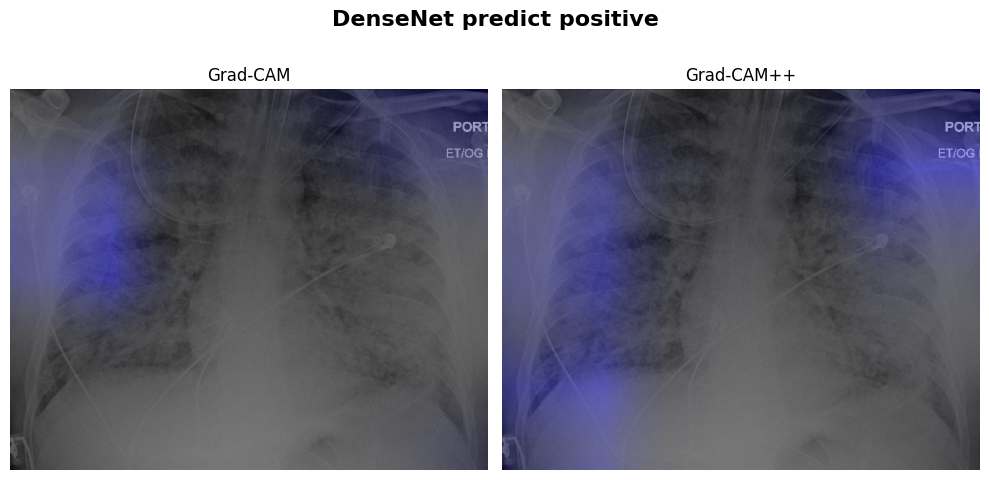

In [16]:
densenet_v_rs = MyDenseNet()
densenet_rs, densenet_stats_rs = train_model(densenet_v_rs, resampled_train_loader, resampled_validation_loader, epochs = 10)
dn_t_loss_rs, dn_t_prec_rs, dn_t_rec_rs, dn_t_f1_rs, dn_v_loss_rs, dn_v_prec_rs, dn_v_rec_rs, dn_v_f1_rs, dn_time_rs = densenet_stats_rs
dn_test_prec_rs, dn_test_rec_rs, dn_test_f1_rs, *dn_test_rest_rs = get_metrics(densenet_rs, resampled_test_loader)
dn_train_prec_rs, dn_train_rec_rs, dn_train_f1_rs, *dn_train_rest_rs = get_metrics(densenet_rs, resampled_train_loader)
dn_rs_pred_pos = 'positive' if (torch.sigmoid(densenet_rs(sample_input_pos)) >= 0.5).item() else 'negative'
dn_rs_pred_neg = 'positive' if (torch.sigmoid(densenet_rs(sample_input_neg)) >= 0.5).item() else 'negative'

plot_loss(10, dn_t_loss_rs, dn_v_loss_rs, 'densenet, resampled')
plot_metric(10, dn_t_f1_rs, dn_v_f1_rs, 'f1 score with each epoch (densenet, resampled)')

for param in densenet_rs.parameters():
    param.requires_grad = True
vis_comparison(densenet_rs, sample_img_pos, sample_input_pos, f'DenseNet predict {dn_rs_pred_pos}')
vis_comparison(densenet_rs, sample_img_neg, sample_input_neg, f'DenseNet predict {dn_rs_pred_neg}')

##### Models Comparison

In [17]:
headers = ['Model', 'Precision', 'Recall', 'F1 Score']
resampled_metrics = [
    ['linearnet (train)', ln_train_prec_rs, ln_train_rec_rs, ln_train_f1_rs],
    ['linearnet (test)', ln_test_prec_rs, ln_test_rec_rs, ln_test_f1_rs],
    ['convnet (train)', cn_train_prec_rs, cn_train_rec_rs, cn_train_f1_rs],
    ['convnet (test)', cn_test_prec_rs, cn_test_rec_rs, cn_test_f1_rs],
    ['resnet (train)', rn_train_prec_rs, rn_train_rec_rs, rn_train_f1_rs],
    ['resnet (test)', rn_test_prec_rs, rn_test_rec_rs, rn_test_f1_rs],
    ['densenet (train)', dn_train_prec_rs, dn_train_rec_rs, dn_train_f1_rs],
    ['densenet (test)', dn_test_prec_rs, dn_test_rec_rs, dn_test_f1_rs]
]
create_table(headers, resampled_metrics)

| Model | Precision | Recall | F1 Score |
| :- | :- | :- | :- |
| linearnet (train) | 0.0051 | 1.0 | 0.0102 |
| linearnet (test) | 0.0 | 0 | 0.0 |
| convnet (train) | 0.0 | 0 | 0.0 |
| convnet (test) | 0.0 | 0 | 0.0 |
| resnet (train) | 0.9847 | 0.772 | 0.8655 |
| resnet (test) | 0.8571 | 0.7021 | 0.7719 |
| densenet (train) | 0.9133 | 0.8364 | 0.8732 |
| densenet (test) | 0.7922 | 0.8592 | 0.8243 |

